In [77]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt

# Create the environment
env = gym.make("CartPole-v1")

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995  # Decay rate for exploration
epsilon_min = 0.01  # Minimum epsilon value
episodes = 10000  # Total number of episodes for training
max_steps = 200  # Maximum steps per episode

# Discretize the state space into buckets
state_bins = [
    np.linspace(-4.8, 4.8, 20),  # Cart position
    np.linspace(-4, 4, 20),  # Cart velocity
    np.linspace(-0.418, 0.418, 20),  # Pole angle
    np.linspace(-4, 4, 20)  # Pole angular velocity
]

# Q-table to store the Q-values
q_table = np.zeros([20, 20, 20, 20, env.action_space.n])

In [91]:
# Function to discretize the state into discrete bins
def discretize_state(state):
    state_idx = []
    for i in range(len(state)):
        state_idx.append(np.digitize(state[i], state_bins[i]) - 1)
    return tuple(state_idx)

In [92]:
# Check if the 'terminated' and 'truncated' are boolean types manually.
def check_terminated_truncated(result):
    obs, reward, terminated, truncated, info = result
    if not isinstance(terminated, bool):
        terminated = bool(terminated)
    if not isinstance(truncated, bool):
        truncated = bool(truncated)
    return obs, reward, terminated, truncated, info

In [93]:
# Test run a single episode
state, _ = env.reset() if isinstance(env.reset(), tuple) else env.reset()
state = discretize_state(state)

total_reward = 0
done = False
step_count = 0

# Run for maximum steps or until the episode ends
while not done and step_count < max_steps:
    # Choose action using epsilon-greedy policy
    if np.random.rand() < epsilon:
        action = env.action_space.sample()  # Explore: random action
    else:
        action = np.argmax(q_table[state])  # Exploit: best action based on Q-values

    # Take action and observe the new state and reward
    next_state_tuple = check_terminated_truncated(env.step(action))
    next_state, reward, done, truncated, info = next_state_tuple  # Unpacking tuple

    next_state = discretize_state(next_state)
    total_reward += reward
    step_count += 1
    state = next_state

print(f"Total reward: {total_reward}, Step count: {step_count}")

Total reward: 142.0, Step count: 142


In [94]:
# Training the Q-learning agent
rewards_per_episode = []

for episode in range(episodes):
    # Reset environment and get the initial state (tuple)
    state, _ = env.reset() if isinstance(env.reset(), tuple) else env.reset()
    state = discretize_state(state)
    total_reward = 0

    for step in range(max_steps):
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(q_table[state])  # Exploit: best action based on Q-values

        # Take action and observe the new state and reward
        next_state_tuple = env.step(action)
        next_state, reward, done, truncated, info = next_state_tuple[:5]  # Unpacking the tuple
        next_state = discretize_state(next_state)

        # Update Q-value using the Q-learning formula
        best_future_q = np.max(q_table[next_state])
        q_table[state + (action,)] = q_table[state + (action,)] + alpha * (
            reward + gamma * best_future_q - q_table[state + (action,)]
        )

        # Update state and accumulate reward
        state = next_state
        total_reward += reward

        if done:
            break

    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_per_episode.append(total_reward)

    # Print progress every 100 episodes
    if episode % 100 == 0:
        print(f"Episode {episode}/{episodes} - Total reward: {total_reward}, Epsilon: {epsilon:.2f}")

# Close the environment after training
env.close()

Episode 0/10000 - Total reward: 200.0, Epsilon: 0.01
Episode 100/10000 - Total reward: 102.0, Epsilon: 0.01
Episode 200/10000 - Total reward: 164.0, Epsilon: 0.01
Episode 300/10000 - Total reward: 135.0, Epsilon: 0.01
Episode 400/10000 - Total reward: 180.0, Epsilon: 0.01
Episode 500/10000 - Total reward: 198.0, Epsilon: 0.01
Episode 600/10000 - Total reward: 200.0, Epsilon: 0.01
Episode 700/10000 - Total reward: 172.0, Epsilon: 0.01
Episode 800/10000 - Total reward: 189.0, Epsilon: 0.01
Episode 900/10000 - Total reward: 200.0, Epsilon: 0.01
Episode 1000/10000 - Total reward: 200.0, Epsilon: 0.01
Episode 1100/10000 - Total reward: 173.0, Epsilon: 0.01
Episode 1200/10000 - Total reward: 162.0, Epsilon: 0.01
Episode 1300/10000 - Total reward: 176.0, Epsilon: 0.01
Episode 1400/10000 - Total reward: 159.0, Epsilon: 0.01
Episode 1500/10000 - Total reward: 138.0, Epsilon: 0.01
Episode 1600/10000 - Total reward: 183.0, Epsilon: 0.01
Episode 1700/10000 - Total reward: 136.0, Epsilon: 0.01
Epis

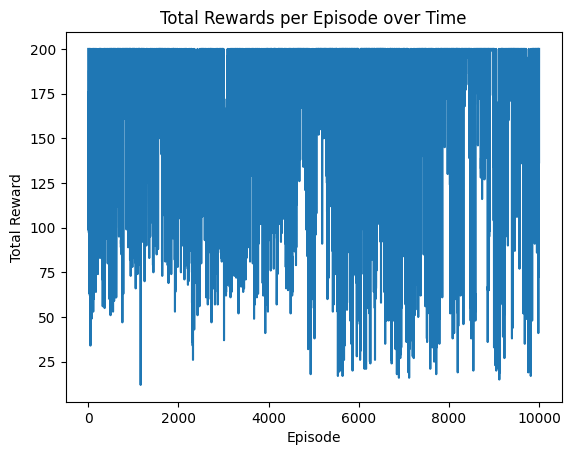

In [96]:
# Plot results (optional)
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Rewards per Episode over Time')
plt.show()